<a href="https://colab.research.google.com/github/AlbertoSalvarese/ML/blob/main/Alberto_Salvarese_Miniproject_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Spectral Clustering** \\
Spectral clustering is an algorithm that performs a clustering not in the original space of data, but in a lower dimensionality space through an embedding of the similarity matrix between the data. Firstly, given a certain similarity relation $s(x_i,x_j)$, it creates an undirected graph between the data points that we have. This graph is then represented in terms of the similarity matrix, whose components ($s_{ij}$) numerically represent how close (similar) two different data-points are. There are several ways to construct a similarity graph: i) the $\epsilon$-neighborhood graph, ii) the k-nearest neighbor graphs, and iii) the fully connected graph.
In the first one, all points whose pairwise distances are smaller than a certain $\epsilon$ are connected. In the second one, the vertex $v_i$ is connected to the vertex $v_j$ if $v_j$ is among the k-nearest points of $v_i$. If $k=1$, than only the closest data-point to $v_i$ can be picked. A first issue of this procedure is that in this way we end up with a connected graph, since we start from a single vertex to connect the others. To deal with that, usually one either connects $v_i$ and $v_j$ if $v_j$ is among the k-nearest points to $v_i$ or $v_i$ is among the k-nearest points to $v_j$ (k-nearest neighbor graph), or connects the two point if $v_j$ is among the k-nearest points to $v_i$ and viceversa (mutual k-nearest neighbor graph).
In the latter case, all the points that share a positive similarity value are connected. However, this construction is useful only if we associate a similarity relation that models local neighborhoods, as the Gaussian function. Here, the standard deviation plays a similar role to $\epsilon$, as it controls the width of the neighborhood.
If in the former method we look at the distances between points to connect them together, the graph's edges are already weighted and comparable between one another, in the other two methods this is not true. So, after having construct the graph, all edges are weighted by the corresponding similarity value.
Once the graph is built, we can compute an adjacency matrix, whose components are the weights $w_{ij}$ between two points. The final goal of spectral clustering is to find partitions of the similarity graph such that the edges between different groups have low $w_{ij}$ (low similarity) and the edges between same groups have high $w_{ij}$ (high similarity). The simplest way to do that is to solve the mincut problem, imposing the different graph's partition to be "reasonably large", otherwise the solution could give just one individual vertex. There are several methods to do that; we will explain the RadioCut (k=2) searching for two clusters. The case for k generic is analogous. A way to impose a partition to be reasonably large is to define an objective function that consider how many vertex a graph-partition has. Once we specify such a function, we can define a vector whose values are positive if a certain vertex belongs to this partition, and negative if it belongs to the partition's complement. If $v_i$ belongs to the partition $A$ of the graph $V$, then $f_i=\sqrt{|\bar{A}|/|A|}$; if instead $v_i$ belongs to $\bar{A}$, $f_i=-\sqrt{|A|/|\bar{A}|}$. 
What most spectral clustering algorithms do is to decompose the vector $f=(f_1,...,f_n)$ and consider its coordinates as points in $\mathbb{R}$. Here, through a k-means algorithm these points are clustered in two groups $C$, and $\bar{C}$. Then if $f_i\in C$, $v_i\in A$, and if $f_i\in\bar{C}$, $v_i\in\bar{A}$.
This is an approximated and "easy" example for seeing how spectral clustering works. It embedds the data-space in a lower-dimensionality space, clusters there the points by means of k-means algorithm, and translates the clustering into the original space.

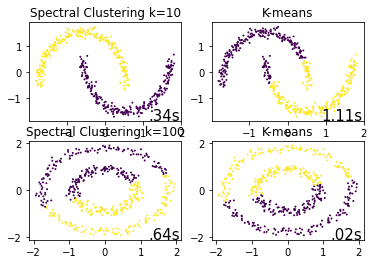

In [13]:
from sklearn.cluster import SpectralClustering   #imports the Spectral Cl. algorithm
from sklearn.cluster import KMeans               #imports the KMeans algorithm
from sklearn.preprocessing import StandardScaler 
import sklearn.datasets
import matplotlib.pyplot as plt
import sklearn as sk                          
import warnings                                  #try to ignore the warning
import time


Ns=500
Nc=2         #number of clusters
Nn=[10,100]  #number of nearest neighbor (hyperparameter of spectral clustering with knn algorithm)

#Data set distributions
moons = sk.datasets.make_moons(n_samples=Ns,noise=0.05)
circles = sk.datasets.make_circles(n_samples=Ns, factor=0.5, noise=0.05)
X = [moons, circles]


plot_number=1

for i in range(len(X)):

    x, y = X[i]

    x = StandardScaler().fit_transform(x) #pre-treats the datapoint

    spectral = SpectralClustering(        #spectral clustering algorithm
        n_clusters=Nc,
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        n_neighbors=Nn[i]                 #two different choices for the nearest neighbor
        )
    kmeans = KMeans(                      #K-means algorithm
        n_clusters=Nc
        )

    algorithms = (                        #set of algorithms
        ("Spectral Clustering k=%s"%Nn[i], spectral),
        ("K-means", kmeans),
        )

    for name, algorithm in algorithms:
        t0 = time.time()

        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )

            algorithm.fit(x)              #it runs the algorithm on x

        labels = algorithm.labels_        #it associate numerical values to each point.
                                          #in the case of two clusters gives 0 (1) to points
                                          #of the first (second) cluster
        t1 = time.time()

        plt.subplot(len(X), len(algorithms), plot_number)
        plt.scatter(x[:,0],x[:,1],s=0.9, c=labels)  #colors given by the labelling above
        plt.title(name)

        plt.text(
            0.99,
            0.01,
            ("%.2fs"%(t1-t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_number+=1

plt.show()

Fig. 1: We see that in the first distribution (noisy moons) the k-means fails in identifying the two clusters, due to the highly non-convex nature of the distribution. Instead, the spectral clustering identifies correctly the clusters. In the second distribution instead, both algorithms fail. This is because for the spectral clustering the k-nearest neighbor (knn) was used, with k=100. So in this case the algorithm fails because it identifies points very far from each other as members of the same similarity graph. With the knn approach, it was suggested to set $k\sim ln(n)$, with $n$ the number of data ([Luxburg (2007)](https://arxiv.org/abs/0711.0189)). Here $n=500$, so an appropriate choice for $k$ would be exactly $10$ as in the first case. 

**Strengths and weaknesses** \\
The power of Spectral Clustering is based on the fact that it does not need any assumption on the distributions' shape ([Luxburg (2007)](https://arxiv.org/abs/0711.0189)). It can efficiently recognize clusters in highly non convex manifolds, as opposed to k-means algorithm, which, on the other hand, are more powerful in convex sets of data. For example, it is computationally more efficient using k-means algorithm for symmetric 2D Gaussian distributions (Blobs). Also, as long as the similarity matrix is sparse (and, in a way, we can tune that by acting on the similarity function), spectral clustering can be efficiently implemented also for very large sets of data. \\
On the other hand, with respect to k-means the spectral clustering algorithm needs more specifications regarding what method to follow, each of which has pros and cons. The $\epsilon$-neighborhood graph for instance is unable to properly connect regions with different densities of data. This is because once $\epsilon$ is fixed, the method will follow that instruction to connect vertices. The fully connected graph, usually used with a Gaussian similarity function $s(x_i,x_j)\sim \exp(-|x_i-x_j|^2/(2\sigma^2))$ connects points in local neighborhoods, while suppressing the edges between far away points. But in this case, the adjeacency matrix is not sparse, and the algorithm can be unstable. The knn method can instead connect points on different densities. Also, it results in a sparse adjacency matrix and with respect to other graphs suffers less the parameters' choice. However, if we want to cluster with repsect to the density of data, the algorithm can fail. If for instance we have far away high density regions, and a low density one close to one of the formers, the spectral clustering could fail (Luxburg (2007)). In conclusion, if we are facing convex or Gaussian distributions (with a nearly symmetric standard deviation in more than one dimension), k-means is a better choice as its easier and does not require several hyperparameters. If instead the structure of our data is more complex, with different densities but sparse adjacency matrix (clusters are well separated), then spectral clustering outperforms the k-means algorithm.

**Silhouette Score**


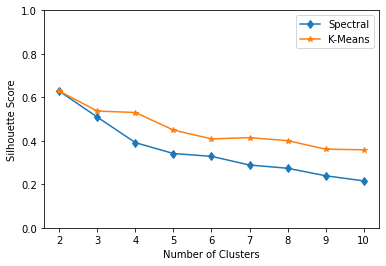

In [9]:
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

#load data-frame
df = pd.read_csv("swiss.csv") 
#create a corresponding array for kmeans and spectral clusterings
DF = pd.DataFrame.to_numpy(df)

#Kmeans and spectral clustering
Nc=[2,3,4,5,6,7,8,9,10]
SC=[]
SC2=[]

for j in range(len(Nc)):
        
    sc = SpectralClustering(n_clusters=Nc[j], affinity="nearest_neighbors").fit(DF)
    k = KMeans(n_clusters=Nc[j]).fit(DF)
    sclabels = sc.labels_
    klabels = k.labels_
    SCssc = metrics.silhouette_score(DF,sclabels,metric='euclidean')
    KMssc = metrics.silhouette_score(DF,klabels,metric='euclidean')

    SC.append(SCssc)
    SC2.append(KMssc)

plt.plot(Nc,SC, label='Spectral',marker='d')
plt.plot(Nc,SC2, label='K-Means',marker='*')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.ylim(0,1)
plt.legend()
plt.show()

In terms of the Silhouette score, the cluster solution does not seem a great option. The Score is always below $0.4$ in a range $0$-to-$1$. \\
The different choices of clustering methods show approximately the same results.

By plotting each possible couple of variables ($15$ in total). It is possible to recognize some clusters. Since the two algorithm are not very different, we will consider the spectral clustering results as example. \\

$N=2$: In "fertility vs catholic", "examination vs catholic", and "education vs catholic" two blob-shaped clusters are easily recognized. Also in "agricolture vs catholic" two distinct clusters (plus maybe some outlier)  appear. From the former to the latter, the higher percentage of catholic corresponds to a more or less equal fertility (slightly higher), a lower examination percentage, an equal education percentage, and an equal agricolture percentage (low catholic cluster not well defined). \\
In "catholic vs mortality" there seem to be two defined clusters (shaped as Gaussian with a very high standard deviation along the mortality axis). There are a few points in between that are incorporated in one of the two clusters. Because of the high uncertainty along the y axis, the mortality percentage seems to be the same for higher and lower catholic percentages. While the vertical distribution of the more catholic cluster has a very low standard deviation along the x-axis, the less catholic one seems to be broader towards higher "catholic" values. \\
Other possible trends are a nearly (increasing) monotonic trend in the "fertility vs agricolture", a nearly (decreasing) trend in "fertility vs examination", and in "agricolture vs examination". All the other distributions seem to be more or less Gaussian-shaped, with identified clusters that are very close together, and that maybe caused the Silhouette score to get such low values. \\

$N=3$: no improvements. Some data-points that seemed as outliers in the $N=2$ case here are marked as members of a third cluster. For instance, the data points in between the higher and the lower catholic percentage in "catholic vs mortality" are now seen as a third cluster. \\

For all the other cases the situation is the one described above. Adding more and more cluster does not provide more insights in the distributions. Maybe some (very small) group of outliers is identified but since these correspond to few and very sparse points, this could just be because of high standard deviations of the distributions.

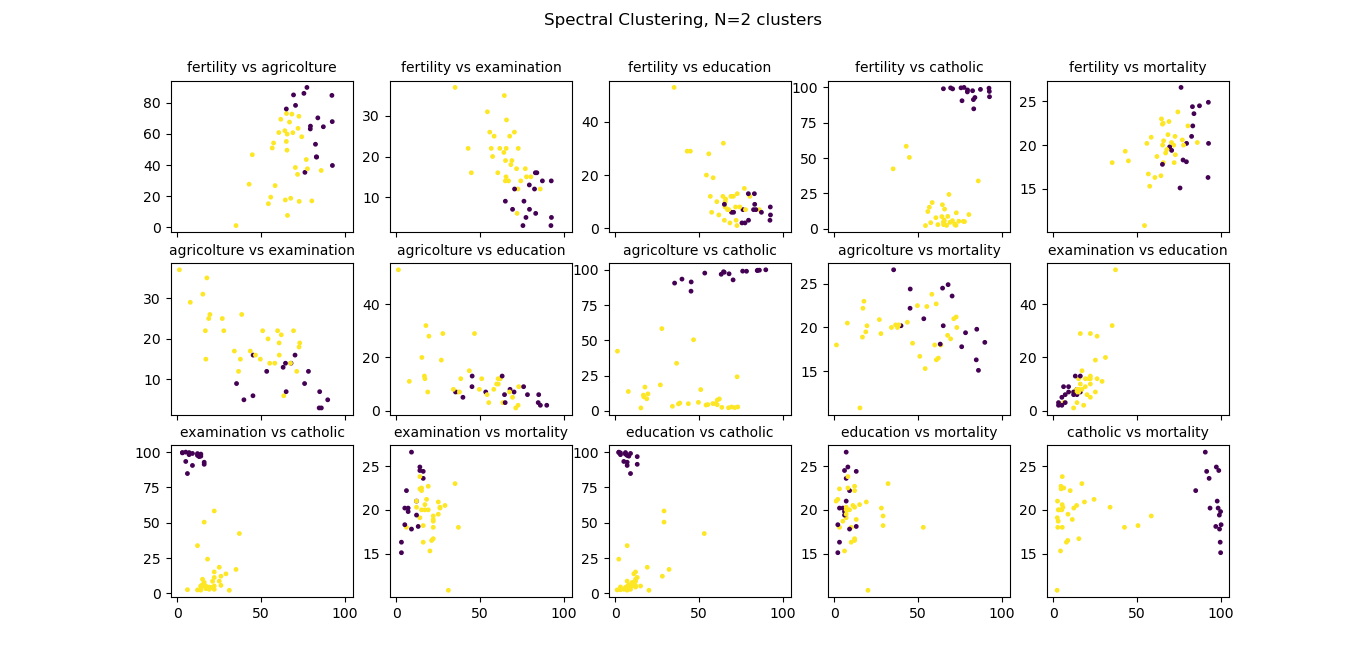